# Feature Selection

In [1]:
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set()

## Load data

In [2]:
filename = 'train.csv' 
df = pd.read_csv(filename)
df.head()

/Users/dahliaradif/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


# Preprocess data

In [3]:
print("Before")
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)
print(df[df.FieldPosition.isnull()][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']].head())

# Handle 50 YardLine by filling in the null 'FieldPositions' with the value in 'PossessionTeam'
df.FieldPosition.fillna(df.PossessionTeam, inplace=True)

print("After")
field_positions = df['FieldPosition']
print(sum(field_positions.isnull()==True))
print(df.shape)
print(df[198:203][['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine']])

Before
6424
(509762, 49)
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801           NaN             KC        50
199  2017090700  20170907000801           NaN             KC        50
200  2017090700  20170907000801           NaN             KC        50
201  2017090700  20170907000801           NaN             KC        50
202  2017090700  20170907000801           NaN             KC        50
After
0
(509762, 49)
         GameId          PlayId FieldPosition PossessionTeam  YardLine
198  2017090700  20170907000801            KC             KC        50
199  2017090700  20170907000801            KC             KC        50
200  2017090700  20170907000801            KC             KC        50
201  2017090700  20170907000801            KC             KC        50
202  2017090700  20170907000801            KC             KC        50


In [4]:
print("Before")
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

# Only keep entries associated with rusher
df = df[df['NflIdRusher']==df['NflId']]
df.reset_index(drop=True, inplace=True)

print("After")
print(df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards']])
print(df.shape)

Before
       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000118            NE             NE        35      8
2  2017090700  20170907000118            NE             NE        35      8
3  2017090700  20170907000118            NE             NE        35      8
4  2017090700  20170907000118            NE             NE        35      8
(509762, 49)
After
       GameId          PlayId FieldPosition PossessionTeam  YardLine  Yards
0  2017090700  20170907000118            NE             NE        35      8
1  2017090700  20170907000139            NE             NE        43      3
2  2017090700  20170907000189            KC             NE        35      5
3  2017090700  20170907000345            KC             NE         2      2
4  2017090700  20170907000395            KC             KC        25      7
(23171, 49)


In [5]:
df['YardsRemaining'] = 100 - df.YardLine[df.FieldPosition == df.PossessionTeam]
df.YardsRemaining.fillna(df.YardLine, inplace=True)
df.head()[['GameId', 'PlayId', 'FieldPosition', 'PossessionTeam', 'YardLine', 'Yards', 'YardsRemaining']]

,GameId,PlayId,FieldPosition,PossessionTeam,YardLine,Yards,YardsRemaining
0,2017090700,20170907000118,NE,NE,35,8,65.0
1,2017090700,20170907000139,NE,NE,43,3,57.0
2,2017090700,20170907000189,KC,NE,35,5,35.0
3,2017090700,20170907000345,KC,NE,2,2,2.0
4,2017090700,20170907000395,KC,KC,25,7,75.0


Before
1 in Box Count: 1
2 in Box Count: 1
NaN in Box Count: 3
After
1 in Box Count: 0
2 in Box Count: 0
NaN in Box Count: 0


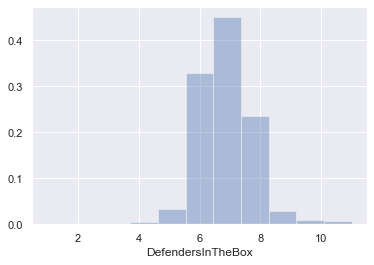

In [6]:
print("Before")
print("1 in Box Count:", len(df[df.DefendersInTheBox==1]))
print("2 in Box Count:", len(df[df.DefendersInTheBox==2]))
print("NaN in Box Count:", sum(df.DefendersInTheBox.isnull()))
sns.distplot(df.DefendersInTheBox[df.DefendersInTheBox.isnull()==False], bins=11, kde=False, norm_hist=True)

# Fill nan with median (i.e. 7), and bump 1 or 2 (few samples) up to 3
df.DefendersInTheBox.fillna(7, inplace=True)
df.DefendersInTheBox.replace(to_replace=[1, 2], value=3, inplace=True)

print("After")
print("1 in Box Count:", len(df[df.DefendersInTheBox==1]))
print("2 in Box Count:", len(df[df.DefendersInTheBox==2]))
print("NaN in Box Count:", sum(df.DefendersInTheBox.isnull()))

## Split data

In [7]:
train, dev = train_test_split(df, test_size=0.3, random_state=1, shuffle=True)
print(train.shape)
print(dev.shape)

(16219, 50)
(6952, 50)


# Feature Selection

In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [9]:
#Tree-based feature selection¶
X, y = df[["YardsRemaining", "DefendersInTheBox", "A"]], df.Yards
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
tree_features = model.transform(X)
print(clf.feature_importances_)
    

# K-best feature selection
k_best_features = SelectKBest(chi2, k=2).fit_transform(X, y)
print(k_best_features)


[0.24531554 0.02729161 0.72739285]
[[65.    3.35]
 [57.    2.41]
 [35.    2.42]
 ...
 [66.    3.68]
 [25.    2.43]
 [23.    4.1 ]]
